In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io

import os
import cv2
import random
import math
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras

from random import sample
from PIL import Image
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation, RandomFlip, Conv2D, MaxPooling2D, RandomZoom, RandomRotation
from keras import regularizers
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import EfficientNetB0, ResNet50, VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from keras.preprocessing import image

In [8]:
! wget https://www.dropbox.com/sh/38zygdpo6u7alwy/AAB1PJuhqF-58GZJ-oD4xl5Ya?dl=0

--2023-12-11 07:02:28--  https://www.dropbox.com/sh/38zygdpo6u7alwy/AAB1PJuhqF-58GZJ-oD4xl5Ya?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/38zygdpo6u7alwy/AAB1PJuhqF-58GZJ-oD4xl5Ya [following]
--2023-12-11 07:02:28--  https://www.dropbox.com/sh/raw/38zygdpo6u7alwy/AAB1PJuhqF-58GZJ-oD4xl5Ya
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucce405280238d56e4c1a216394f.dl.dropboxusercontent.com/zip_download_get/Bsl4-cd3WgkLrsZt6kerpLEJiwBLeVeh7xHH9afkrSeY4jFxlCurnQafKR_8NwaHKnGZ8tB0kQEH8pmQYpXAXUWENC1op14C4m4SGsHInDDCLQ# [following]
--2023-12-11 07:02:29--  https://ucce405280238d56e4c1a216394f.dl.dropboxusercontent.com/zip_download_get/Bsl4-cd3WgkLrsZt6kerpLEJiwBLeVeh7xHH9afkrSeY4jFxlCurnQafKR_8NwaHKnGZ8tB0kQEH8pmQYpXAXUWENC1o

In [9]:
with zipfile.ZipFile("AAB1PJuhqF-58GZJ-oD4xl5Ya?dl=0","r") as zip_ref:
    zip_ref.extractall("data")

In [10]:
with zipfile.ZipFile("data/data.zip","r") as zip_ref:
    zip_ref.extractall("data")

In [11]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [12]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/MyDrive/Colab Notebooks/mlds-project/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/MyDrive/Colab Notebooks/mlds-project/val_source_images.txt')
test_ids = load_text_ids('/content/drive/MyDrive/Colab Notebooks/mlds-project/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Loading and pre processing the data
### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [14]:
def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')

        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')

        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])

        # Normalize the image to the [0, 1] range
        img = img / 255.0

        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0

        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([])

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 128
batch_size = 64

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

In [15]:
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

kernel_size = (3, 3)
pool_size = (2, 2)
dropout_rate = 0.3
dense_neurons = 64
batch_size = 32

In [ ]:
# CNN
model = Sequential()
# Input Layer
model.add(Input(shape=(299, 299, 3)))
# Data augmentation layer
model.add(data_augmentation)

# First Convolutional Block
model.add(Conv2D(16, kernel_size, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(dropout_rate))

# Second Convolutional Block
model.add(Conv2D(32, kernel_size, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(dropout_rate))

# Third Convolutional Block
model.add(Conv2D(64, kernel_size, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(dropout_rate))

model.add(Flatten())
model.add(Dense(dense_neurons, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(2, activation='softmax'))

# model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(tf_dataset_train, epochs=20, verbose=1, validation_data=tf_dataset_val, callbacks=early_stopping)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 299, 299, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 297, 297, 16)      448       
                                                                 
 batch_normalization_20 (Ba  (None, 297, 297, 16)      64        
 tchNormalization)                                               
                                                                 
 activation_20 (Activation)  (None, 297, 297, 16)      0         
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 148, 148, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 148, 148, 16)    

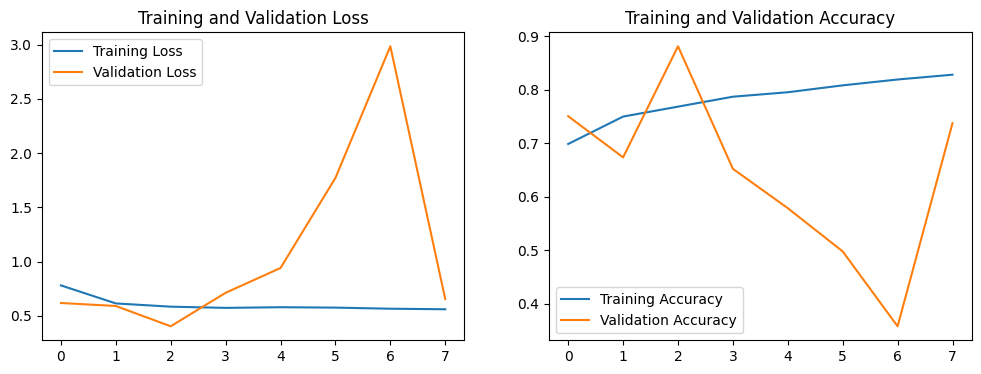

In [ ]:
# training and validation errors
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(tf_dataset_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

201/201 [==============================] - 78s 386ms/step - loss: 0.6295 - accuracy: 0.8092
Test Loss: 0.6295273303985596, Test Accuracy: 0.8092489838600159


In [21]:
def eval_model(model, tf_data):
    y_true = []
    y_pred = []
    for batch_data, batch_label in tf_data:
        preds = model.predict(batch_data)
        # print(preds)
        # print(batch_label)
        y_true.extend(batch_label.numpy().astype(int))
        y_pred.extend(np.argmax(preds, axis=1).astype(int))
    # print(y_pred)
    # print("##")
    # print(y_true)
    print("Confusion_matrix")
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Frost', 'Frost'], yticklabels=['Non-Frost', 'Frost'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print("Classification Report: ")
    print(classification_report(y_true, y_pred))

Evaluation for CNN
1/1 [==============================] - 0s 37ms/step
confusion_matrix


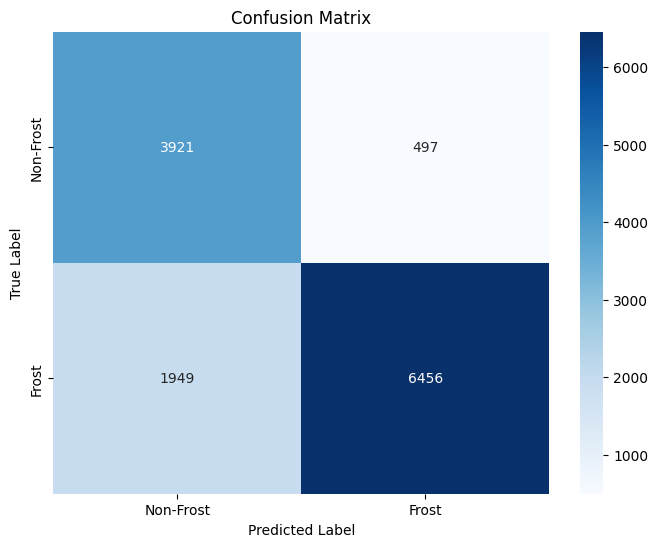

classification report
              precision    recall  f1-score   support

           0       0.67      0.89      0.76      4418
           1       0.93      0.77      0.84      8405

    accuracy                           0.81     12823
   macro avg       0.80      0.83      0.80     12823
weighted avg       0.84      0.81      0.81     12823



In [ ]:
print("Evaluation for CNN")
eval_model(model, tf_dataset_test)

# Transfer Learning

In [17]:
# EfficientNetB0
efficientnet = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(299,299,3))
efficientnet.trainable=False

model_en = Sequential()
model_en.add(Input(shape=(299, 299, 3)))
model_en.add(data_augmentation)
model_en.add(efficientnet)

model_en.add(Flatten())
model_en.add(BatchNormalization())
model_en.add(Dropout(dropout_rate))
model_en.add(Dense(1024, activation='relu'))
model_en.add(BatchNormalization())
model_en.add(Dropout(dropout_rate))
model_en.add(Dense(2, activation='softmax'))

model_en.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model_en.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


history_en = model_en.fit(tf_dataset_train, epochs=10, verbose=1, validation_data=tf_dataset_val, callbacks=early_stopping)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 10, 10, 1280)      4049571   
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 128000)            0         
                                                                 
 batch_normalization_4 (Bat  (None, 128000)            512000    
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 128000)            0         
                                                                 
 dense_4 (Dense)             (None, 1024)             

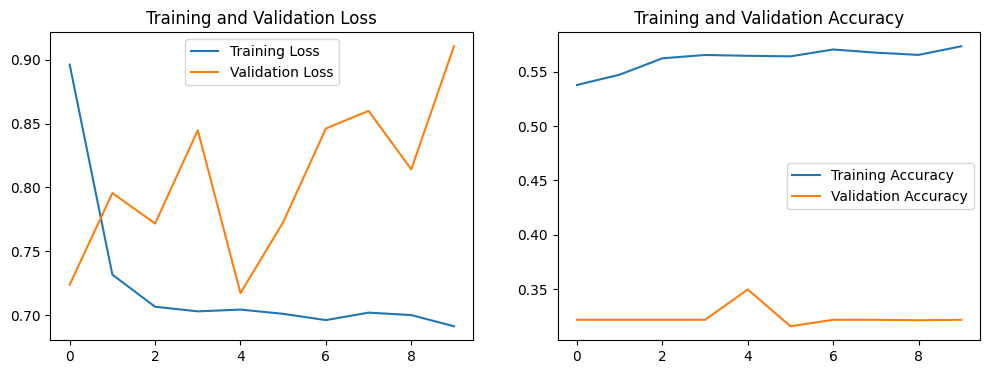

In [18]:
# training and validation errors
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_en.history['loss'], label='Training Loss')
plt.plot(history_en.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history_en.history['accuracy'], label='Training Accuracy')
plt.plot(history_en.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [19]:
test_loss, test_accuracy = model_en.evaluate(tf_dataset_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

201/201 [==============================] - 113s 557ms/step - loss: 0.6775 - accuracy: 0.5196
Test Loss: 0.6775211095809937, Test Accuracy: 0.5196132063865662


Evaluation for EfficientNetB0
1/1 [==============================] - 2s 2s/step
Confusion_matrix


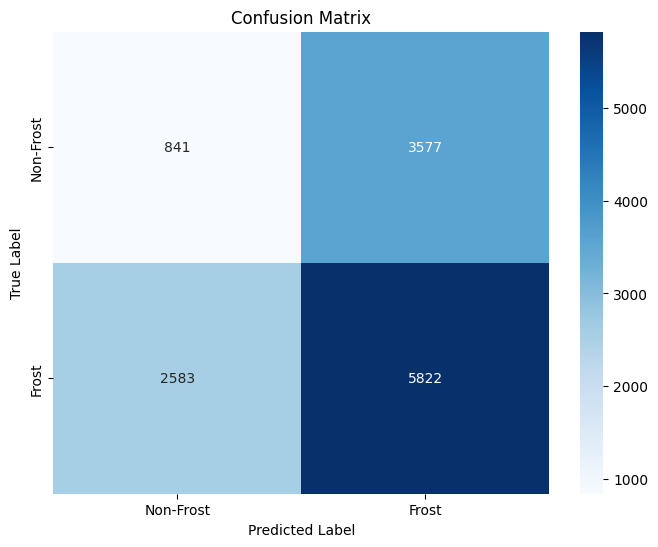

Classification Report: 
              precision    recall  f1-score   support

           0       0.25      0.19      0.21      4418
           1       0.62      0.69      0.65      8405

    accuracy                           0.52     12823
   macro avg       0.43      0.44      0.43     12823
weighted avg       0.49      0.52      0.50     12823



In [23]:
print("Evaluation for EfficientNetB0")
eval_model(model_en, tf_dataset_test)

In [24]:
# ResNet50
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(299,299,3))
restnet.trainable=False

model_r = Sequential()
model_r.add(Input(shape=(299, 299, 3)))
model_r.add(data_augmentation)
model_r.add(restnet)

model_r.add(Flatten())
model_r.add(BatchNormalization())
model_r.add(Dropout(dropout_rate))
model_r.add(Dense(1024, activation='relu'))
model_r.add(BatchNormalization())
model_r.add(Dropout(dropout_rate))
model_r.add(Dense(2, activation='softmax'))

model_r.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model_r.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


history_r = model_r.fit(tf_dataset_train, epochs=10, verbose=1, validation_data=tf_dataset_val, callbacks=early_stopping)

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten_3 (Flatten)         (None, 204800)            0         
                                                                 
 batch_normalization_6 (Bat  (None, 204800)            819200    
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 204800)            0         
                                                                 
 dense_6 (Dense)             (None, 1024)              

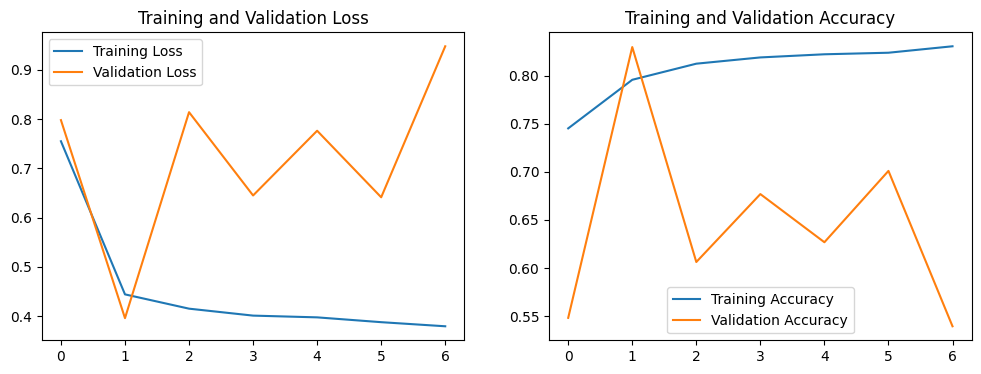

In [25]:
# training and validation errors
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_r.history['loss'], label='Training Loss')
plt.plot(history_r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history_r.history['accuracy'], label='Training Accuracy')
plt.plot(history_r.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [26]:
test_loss, test_accuracy = model_r.evaluate(tf_dataset_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

201/201 [==============================] - 143s 709ms/step - loss: 0.3117 - accuracy: 0.8690
Test Loss: 0.31165748834609985, Test Accuracy: 0.8689854145050049


Evaluation for ResNet50
1/1 [==============================] - 1s 1s/step
Confusion_matrix


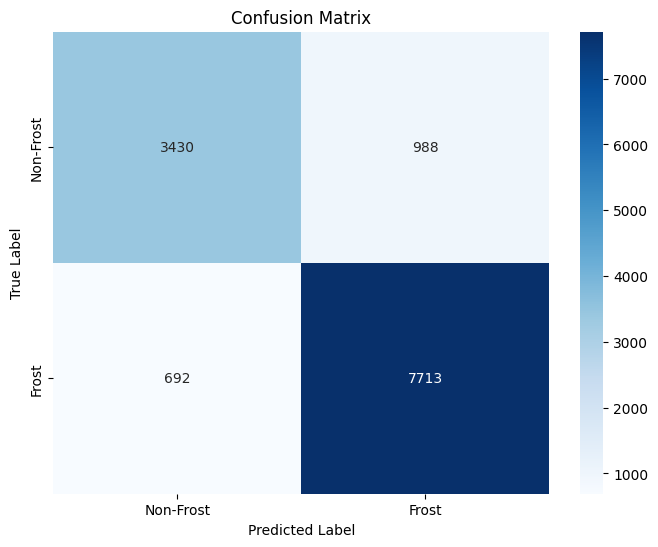

Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      4418
           1       0.89      0.92      0.90      8405

    accuracy                           0.87     12823
   macro avg       0.86      0.85      0.85     12823
weighted avg       0.87      0.87      0.87     12823



In [29]:
print("Evaluation for ResNet50")
eval_model(model_r, tf_dataset_test)

In [30]:
# VGG16
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(299,299,3))
vgg16.trainable=False

model_vgg = Sequential()
model_vgg.add(Input(shape=(299, 299, 3)))
model_vgg.add(data_augmentation)
model_vgg.add(vgg16)

model_vgg.add(Flatten())
model_vgg.add(BatchNormalization())
model_vgg.add(Dropout(dropout_rate))
model_vgg.add(Dense(1024, activation='relu'))
model_vgg.add(BatchNormalization())
model_vgg.add(Dropout(dropout_rate))
model_vgg.add(Dense(2, activation='softmax'))

model_vgg.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model_vgg.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


history_vgg = model_vgg.fit(tf_dataset_train, epochs=10, verbose=1, validation_data=tf_dataset_val, callbacks=early_stopping)

58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 41472)             0         
                                                                 
 batch_normalization_8 (Bat  (None, 41472)             165888    
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 41472)             0         
                                                                 
 dense_8 (Dense)             (None, 1024)              

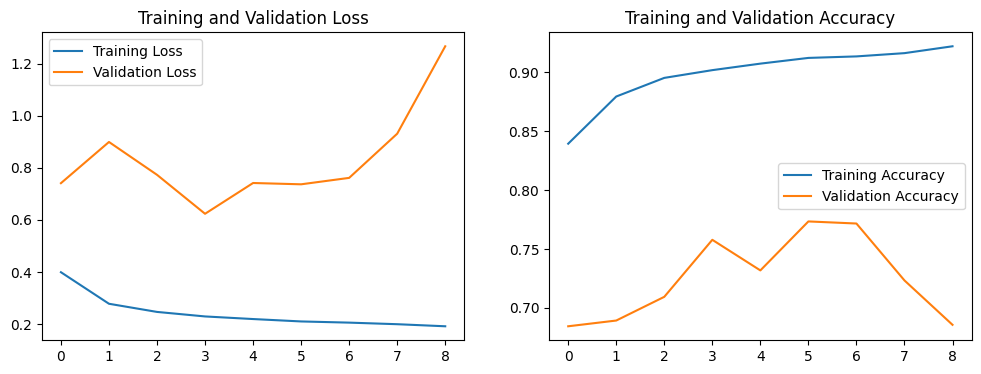

In [31]:
# training and validation errors
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [34]:
test_loss, test_accuracy = model_vgg.evaluate(tf_dataset_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

201/201 [==============================] - 168s 823ms/step - loss: 0.2704 - accuracy: 0.8964
Test Loss: 0.27038460969924927, Test Accuracy: 0.8963581323623657


Evaluation for VGG16
1/1 [==============================] - 0s 233ms/step
Confusion_matrix


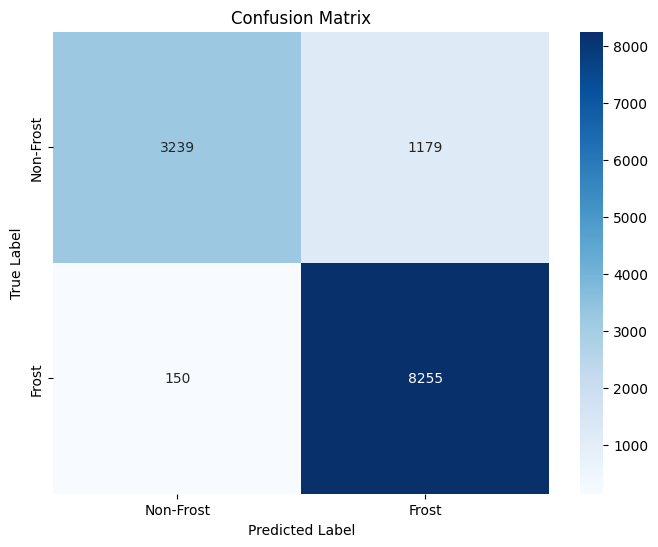

Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.73      0.83      4418
           1       0.88      0.98      0.93      8405

    accuracy                           0.90     12823
   macro avg       0.92      0.86      0.88     12823
weighted avg       0.90      0.90      0.89     12823



In [35]:
print("Evaluation for VGG16")
eval_model(model_vgg, tf_dataset_test)

# Comparison

- The CNN model works good with little adjustments. But the early stopping conditions does not let it complete all the 20 epoches.
- Same thing is seen with RestNetB0. Both of them have almost the same accuracies.
- EfficientNetB0 gives a the least accuracy compared too all of the other models.
- VGG16 gives the best accuracy.